# CS 3540 Final Project - Classifying human emotion in audio clips.
Nathan Blanchard, Skyler Heininger, Eric Seligmann, Henry Kraessig

## Google Colab Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS3540 Final Project/Notebooks'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['extract_filename_features.py', 'extract_audio_features.py', 'data', 'normalize_data.py', 'svm.ipynb', 'load_train_test_split.ipynb', 'Neural outputs.gdoc', 'Neural Network.ipynb', 'decision_tree_random_forest.ipynb', 'pca_and_svm.ipynb']


## Import Statements

In [3]:
# load needed libraries.
import numpy as np
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [4]:
GOOGLE_DRIVE_PATH

'drive/MyDrive/CS3540 Final Project/Notebooks'

In [7]:
%run "{GOOGLE_DRIVE_PATH}/load_train_test_split.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['extract_filename_features.py', 'extract_audio_features.py', 'data', 'normalize_data.py', 'svm.ipynb', 'load_train_test_split.ipynb', 'Neural outputs.gdoc', 'Neural Network.ipynb', 'decision_tree_random_forest.ipynb', 'pca_and_svm.ipynb']


## Prepare the Data
Load the features and split into training and testing sets for predicting emotion and intensity separately

In [9]:
def split_features_label(input_df):
  features = input_df.iloc[:, 1:89]
  labels = input_df.iloc[:, 89:]
  return features, labels

# Load the data
train, test = gen_train_test_split()

train_val, val, test_val = gen_train_val_test_split()

x_train, y_train = split_features_label(train)
print(x_train.shape)
print(y_train.shape)
x_test, y_test = split_features_label(test)

(1140, 88)
(1140, 2)


In [10]:
y_test

,target,intensity
632,5,2
634,5,2
649,7,2
610,2,2
643,6,2
...,...,...
776,8,2
977,3,2
1159,3,2
959,8,2


## Decision Tree Classifiers



In [13]:
# Create a decision tree classifier
dtree_emo = DecisionTreeClassifier()
dtree_in = DecisionTreeClassifier()

# Train the classifier on the training data
dtree_emo.fit(x_train, y_train['target'])
dtree_in.fit(x_train, y_train['intensity'])

# Extract feature importance
dtree_feature_importance_emo = dtree_emo.feature_importances_
dtree_feature_importance_in = dtree_in.feature_importances_

# Predict
y_pred_emo = dtree_emo.predict(x_test)
y_pred_in = dtree_in.predict(x_test)

# Get the accuracies
accuracy_emo = accuracy_score(y_test['target'], y_pred_emo)
print("Accuracy:", accuracy_emo)
accuracy_in = accuracy_score(y_test['intensity'], y_pred_in)
print("Accuracy:", accuracy_in)

Accuracy: 0.31666666666666665
Accuracy: 0.6433333333333333


Visualize the feature importances from the decision trees

In [14]:
# Visualize feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(features.columns, dtree_feature_importance_emo)
#plt.xlabel('Feature Importance')
#plt.ylabel('Features')
#plt.title('Decision Tree Feature Importance')
#plt.show()

#plt.figure(figsize=(10, 6))
#plt.barh(features.columns, dtree_feature_importance_in)
#plt.xlabel('Feature Importance')
#plt.ylabel('Features')
#plt.title('Decision Tree Feature Importance')
#plt.show()

Let's try some values for the hyperparameter max_features:
Loop iterating though all possible values for the hyperparameter max_features, creating a tree with max_features = i for each value within the loop, and then displaying a graph that plots the scores for each value i.

In [15]:
# Test out max_features hyperparameter for emotion
scores_emo = []
for i in range(1, x_train.shape[1]):
    dtree = DecisionTreeClassifier(max_features=i).fit(x_train, y_train['target'])
    scores_emo.append(dtree.score(x_test, y_test['target']))

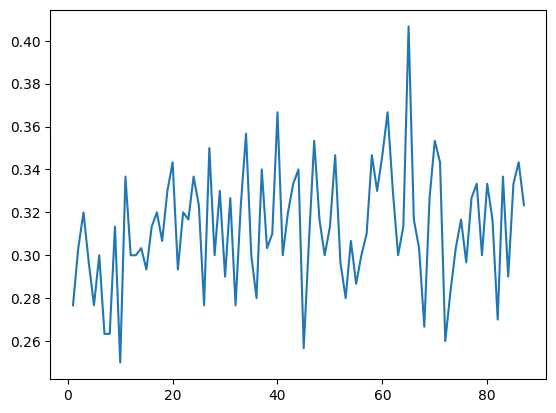

In [16]:
# Plot the scores of each value tried for max_features
x_vals_emo = [i for i in range(1, x_train.shape[1])]
plt.plot(x_vals_emo, scores_emo)

In [17]:
# Test out max_features hyperparameter for intensity
scores_in = []
for i in range(1, x_train.shape[1]):
    dtree = DecisionTreeClassifier(max_features=i).fit(x_train, y_train['intensity'])
    scores_in.append(dtree.score(x_test, y_test['intensity']))

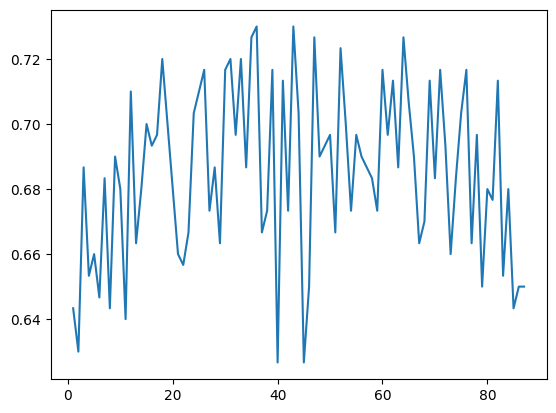

In [18]:
# Plot the scores of each value tried for max_features
x_vals_in = [i for i in range(1, x_train.shape[1])]
plt.plot(x_vals_in, scores_in)

### Confusion Matrix and Precision Recall
Create confusion matricies and calculate precision and recall for the decision tree classifiers

In [19]:
# implement your own code to calacuate precision and recall
def custom_precision_recall(conf_matrix, target_names):
    # write your code here
    pr_df = pd.DataFrame(columns=['Precision', 'Recall'])
    for target in target_names:
        tp = conf_matrix[target][target]
        fp = np.sum(conf_matrix[:, target])-tp
        fn = np.sum(conf_matrix[target])-tp
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        pr_df.loc[len(pr_df)] = [precision, recall]
    return pr_df

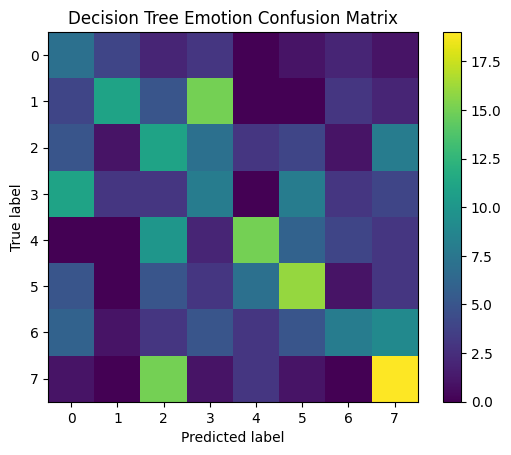

In [20]:
# Create confusion matrix for emotion
conf_matrix_emo = confusion_matrix(y_test['target'], y_pred_emo)
plt.imshow(conf_matrix_emo)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Decision Tree Emotion Confusion Matrix')
plt.colorbar()
plt.show()

In [21]:
# Calculate precision and recall for emotion
custom_precision_recall(conf_matrix_emo, np.arange(8))

,Precision,Recall
0,0.179487,0.350
1,0.550000,0.275
2,0.203704,0.275
3,0.181818,0.200
4,0.483871,0.375
5,0.390244,0.400
6,0.363636,0.200
7,0.387755,0.475


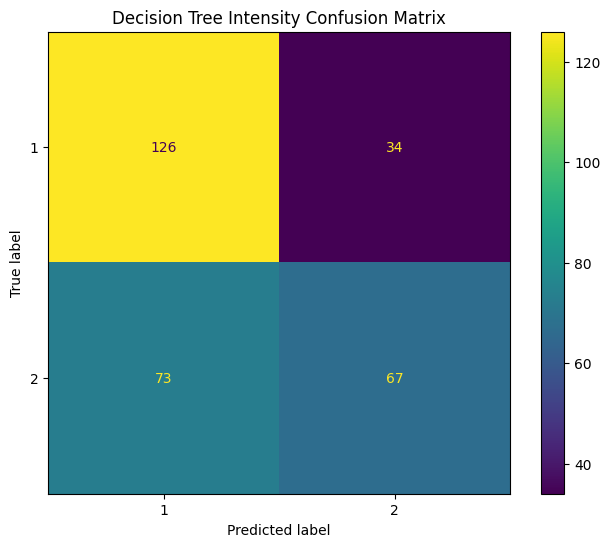

In [22]:
# Create confusion matrix for intensity
conf_matrix_in = confusion_matrix(y_test['intensity'], y_pred_in)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_in, display_labels=dtree_in.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

ax.set_title('Decision Tree Intensity Confusion Matrix')

plt.show()

In [23]:
# Calculate precision and recall for intensity
custom_precision_recall(conf_matrix_in, np.arange(2))

,Precision,Recall
0,0.633166,0.787500
1,0.663366,0.478571


## Random Forest Classifiers


In [24]:
# Create a random forest classifier
rfc_emo = RandomForestClassifier()
rfc_in = RandomForestClassifier()

# Train the classifier on the training data
rfc_emo.fit(x_train, y_train['target'])
rfc_in.fit(x_train, y_train['intensity'])

# Extract feature importance
rfc_feature_importance_emo = rfc_emo.feature_importances_
rfc_feature_importance_in = rfc_in.feature_importances_

# Predict
y_pred_emo = rfc_emo.predict(x_test)
y_pred_in = rfc_in.predict(x_test)

# Get the accuracies
accuracy_emo = accuracy_score(y_test['target'], y_pred_emo)
print("Accuracy:", accuracy_emo)
accuracy_in = accuracy_score(y_test['intensity'], y_pred_in)
print("Accuracy:", accuracy_in)

Accuracy: 0.4533333333333333
Accuracy: 0.7733333333333333


Visualize the feature importances from the random forests

In [ ]:
# Visualize feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(features.columns, rfc_feature_importance_emo)
#plt.xlabel('Feature Importance')
#plt.ylabel('Features')
#plt.title('Random Forest Emotion Feature Importance')
#plt.show()

#plt.figure(figsize=(10, 6))
#plt.barh(features.columns, rfc_feature_importance_in)
#plt.xlabel('Feature Importance')
#plt.ylabel('Features')
#plt.title('Random Forest Intensity Feature Importance')
#plt.show()

Let's try some values for the hyperparameter max_features:
Loop iterating though all possible values for the hyperparameter max_features, creating a tree with max_features = i for each value within the loop, and then displaying a graph that plots the scores for each value i.

In [25]:
# Test out max_features hyperparameter for emotion
scores_emo = []
for i in range(10, 301, 10):
    rforest = RandomForestClassifier(n_estimators=i).fit(x_train, y_train['target'])
    scores_emo.append(rforest.score(x_test, y_test['target']))

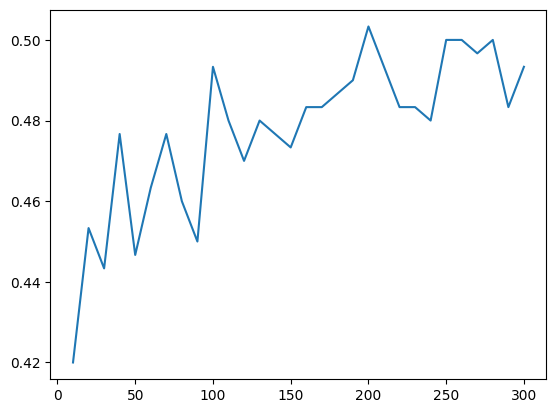

In [26]:
# Plot the scores of each value tried for max_features
x_vals_emo = [i for i in range(10, 301, 10)]
plt.plot(x_vals_emo, scores_emo)

In [27]:
# Test out max_features hyperparameter for intensity
scores_in = []
for i in range(10, 301, 10):
    rforest = RandomForestClassifier(n_estimators=i).fit(x_train, y_train['intensity'])
    scores_in.append(rforest.score(x_test, y_test['intensity']))

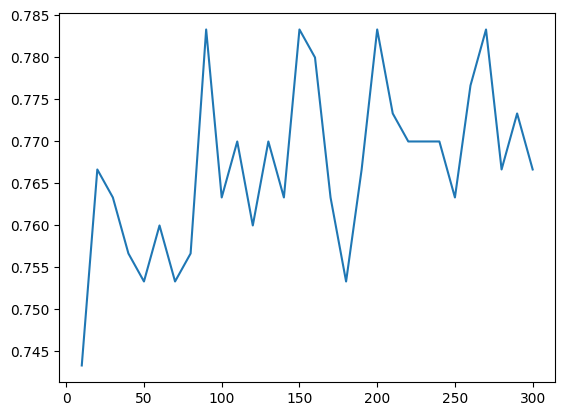

In [28]:
# Plot the scores of each value tried for max_features
x_vals_in = [i for i in range(10, 301, 10)]
plt.plot(x_vals_in, scores_in)

In [37]:
# Train new models that use n_estimators=100
# Create a random forest classifier
rfc_emo = RandomForestClassifier(n_estimators=100)
rfc_in = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
rfc_emo.fit(x_train, y_train['target'])
rfc_in.fit(x_train, y_train['intensity'])

# Predict
y_pred_emo = rfc_emo.predict(x_test)
y_pred_in = rfc_in.predict(x_test)

# Get the accuracies
accuracy_emo = accuracy_score(y_test['target'], y_pred_emo)
print("Accuracy:", accuracy_emo)
accuracy_in = accuracy_score(y_test['intensity'], y_pred_in)
print("Accuracy:", accuracy_in)

Accuracy: 0.45666666666666667
Accuracy: 0.7766666666666666


### Confusion Matrix and Precision Recall
Create confusion matricies and calculate precision and recall for the decision tree classifiers

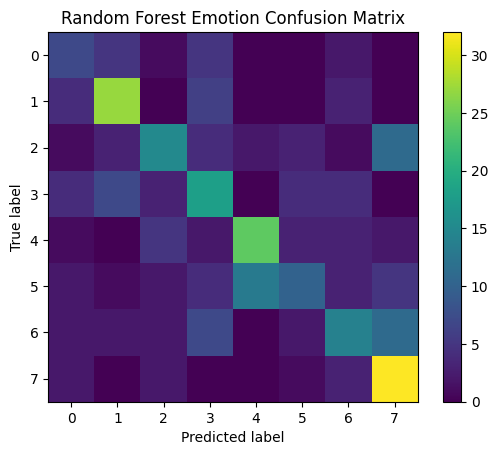

In [32]:
# Create confusion matrix for emotion
conf_matrix_emo = confusion_matrix(y_test['target'], y_pred_emo)
plt.imshow(conf_matrix_emo)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Emotion Confusion Matrix')
plt.colorbar()
plt.show()

In [33]:
# Calculate precision and recall for emotion
custom_precision_recall(conf_matrix_emo, np.arange(8))

,Precision,Recall
0,0.304348,0.350
1,0.600000,0.675
2,0.500000,0.375
3,0.391304,0.450
4,0.615385,0.600
5,0.434783,0.250
6,0.424242,0.350
7,0.524590,0.800


[]

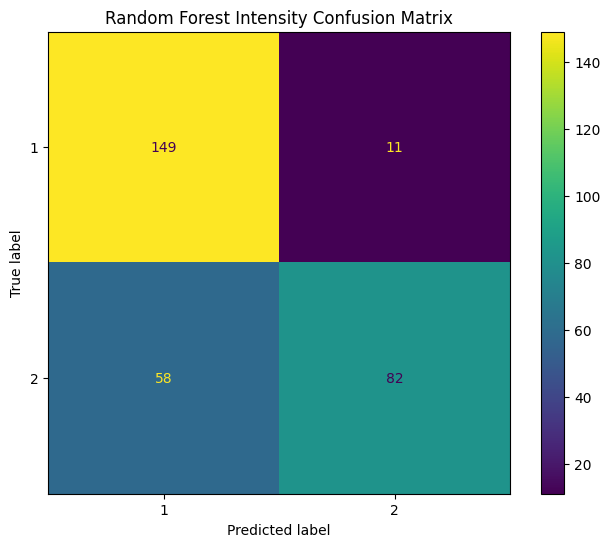

In [34]:
# Create confusion matrix for intensity
conf_matrix_in = confusion_matrix(y_test['intensity'], y_pred_in)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_in, display_labels=rfc_in.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

ax.set_title('Random Forest Intensity Confusion Matrix')
plt.plot()

In [35]:
# Calculate precision and recall for intensity
custom_precision_recall(conf_matrix_in, np.arange(2))

,Precision,Recall
0,0.719807,0.931250
1,0.881720,0.585714
